In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler, normalize
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [2]:
train = pd.read_csv('data/train.csv')
train.shape

(5380, 767)

In [3]:
test = pd.read_csv('data/test.csv')
test.shape

(4403, 766)

## Missing Values

In [4]:
num_missing = train.isna().sum().sum()
print(num_missing)

num_cols_missing = (train.isna().any()).sum()
print(num_cols_missing)

num_rows_missing = (train.isna().any(axis=1)).sum()
print(num_rows_missing)

29911
473
2523


In [5]:
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

In [6]:
col_id = test['id']
X_test = test.drop(['id'], axis = 1)

### KNN

In [7]:
imputer = KNNImputer(n_neighbors = 5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

## Feature Selection

### Drop column of 0/1s

In [9]:
X_train1 = X_train.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
X_test1 = X_test.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
print(X_train1.shape)

(5380, 754)


### Drop column with low variance

In [26]:
#var = X_train.var()
#low_var_col = var[var < 0.01].index.tolist()
#X_train.drop(low_var_col, axis=1, inplace=True)
#X_test.drop(low_var_col, axis=1, inplace=True)
#print(X_train.shape)

### Drop highly correlated columns

In [10]:
corr_matrix = X_train1.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_columns = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

X_train2 = X_train1.drop(corr_columns, axis=1)
X_test2 = X_test1.drop(corr_columns, axis=1)
print(X_train2.shape)

C:\Users\subwa\AppData\Local\Temp\ipykernel_6636\1740002062.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


(5380, 284)


### Lasso Feature Importance

In [11]:
model_lasso_FS = Lasso(alpha=0.25)
model_lasso_FS.fit(X_train2, y_train)

selection = SelectFromModel(model_lasso_FS, threshold=0.15)
selection.fit_transform(X_train2, y_train)
lasso_FI_ind = selection.get_support(indices=True)

lasso_FI = pd.DataFrame({'Feature': X_train2.columns[lasso_FI_ind], 'Importance': model_lasso_FS.coef_[lasso_FI_ind]})
lasso_FI = lasso_FI.sort_values('Importance', ascending=False)
lasso_FI

c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+05, tolerance: 7.767e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+05, tolerance: 7.767e+01
  model = cd_fast.enet_coordinate_descent(


,Feature,Importance
0,x003,0.897129
1,x014,0.875946
3,x105,0.709228
5,x131,0.322714
7,x425,0.303800
9,x561,0.239915
6,x365,0.197699
4,x114,-0.162588
2,x062,-0.187687
11,x626,-0.233993


### XGBoost Feature Importance

>2 11.462 (0.650)
>3 10.845 (0.676)
>4 10.456 (0.608)
>5 10.295 (0.600)
>6 10.172 (0.550)
>7 10.103 (0.513)


Text(0.5, 0, 'Number of trees')

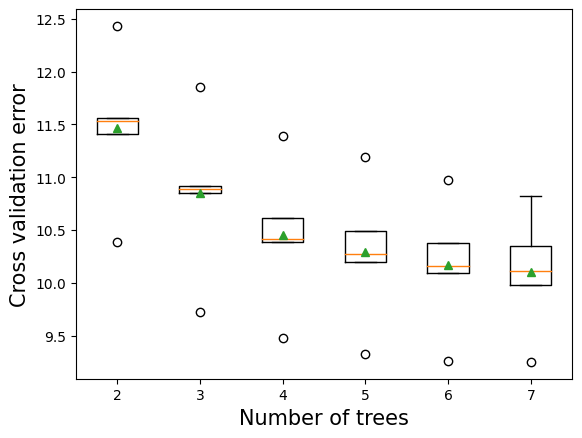

In [58]:
def get_models():
    models = dict()
    for n in range(2, 8):
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train2, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 9.816 (1.182)
>2 9.685 (1.075)
>3 9.725 (1.059)
>4 9.856 (1.096)
>5 9.693 (1.086)
>6 9.838 (1.149)


Text(0.5, 0, 'Depth of each tree')

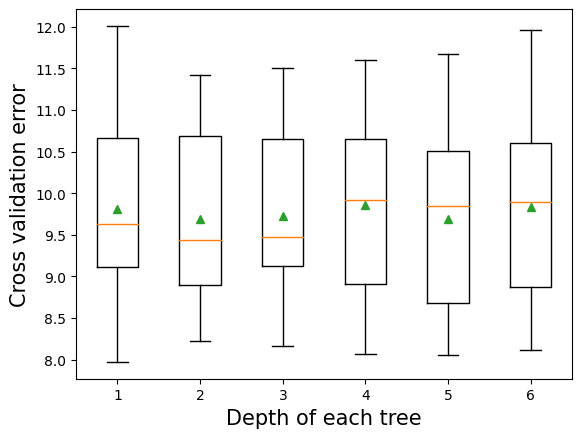

In [60]:
def get_models():
    models = dict()
    for i in range(1, 7):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train2, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0125 10.3 (1.5)
>0.0150 10.0 (1.5)
>0.0175 9.8 (1.4)
>0.0200 9.7 (1.4)


Text(0.5, 0, 'Learning rate')

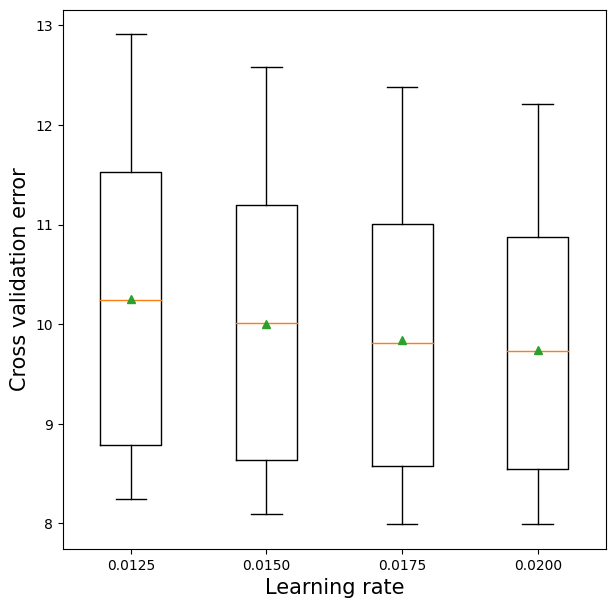

In [61]:
def get_models():
    models = dict()
    for i in [0.0125, 0.015, 0.0175, 0.0200]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train2, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0100 10.0 (1.0)
>0.0500 10.0 (1.0)
>0.1000 10.1 (1.0)
>0.2500 10.0 (1.1)
>0.5000 9.9 (1.0)
>1.0000 9.8 (1.1)


Text(0.5, 0, 'reg_lambda')

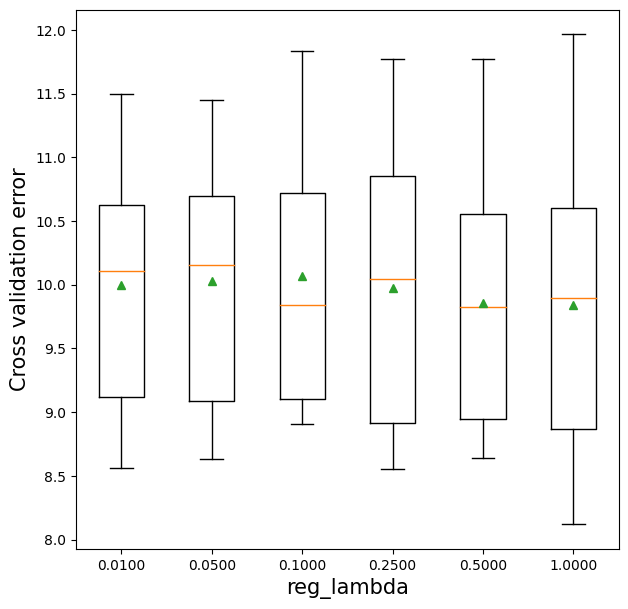

In [63]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train2, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [65]:
param_grid = {'n_estimators':[3],
              'max_depth': [2, 3],
              'learning_rate': [0.014, 0.015],
              'reg_lambda':[0.5, 1]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train2, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Optimal parameter values = {'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 3, 'reg_lambda': 1}
Optimal cross validation R-squared =  -0.4050026878700489


In [66]:
model_XG_FS = xgb.XGBRegressor(n_estimators=3, max_depth=3, learning_rate = 0.015, reg_lambda=1,
                            random_state=1,).fit(X_train2, y_train)

In [91]:
XG_FI = pd.DataFrame({'Feature': X_train2.columns, 'Importance': model_XG_FS.feature_importances_})
XG_FI = XG_FI.sort_values('Importance', ascending=False)
XG_FI = XG_FI[XG_FI['Importance'] >= 0.01]
XG_FI

,Feature,Importance
179,x420,0.338995
72,x114,0.138622
156,x355,0.138319
66,x102,0.104662
234,x585,0.080603
68,x105,0.064432
181,x427,0.059233
226,x561,0.044465
242,x619,0.030669


### RF Feature Importance

In [73]:
warnings.filterwarnings("ignore")

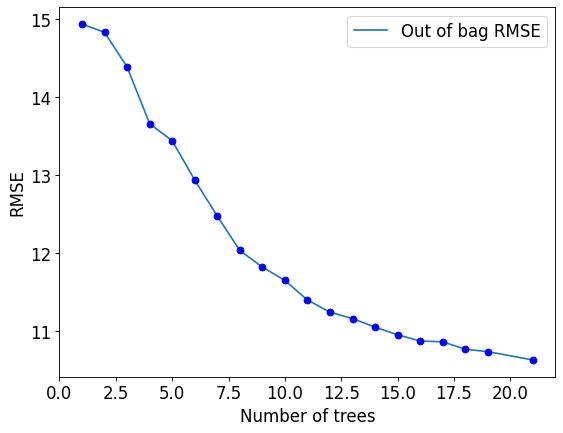

In [75]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in np.linspace(1, 21, 20, dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1, max_features="sqrt",
                                   n_jobs=-1, oob_score=True).fit(X_train2, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

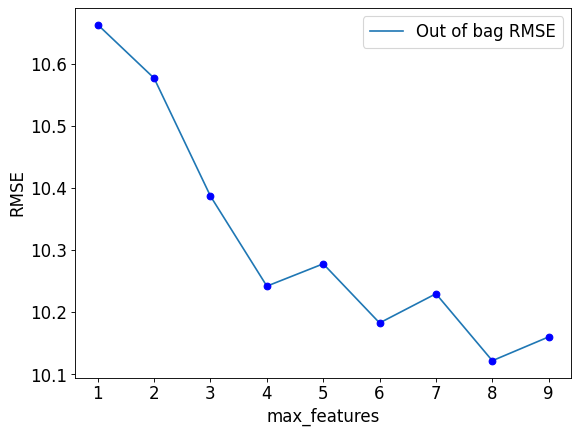

In [76]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in range(1, 10):
    model = RandomForestRegressor(n_estimators=100, random_state=1, max_features=i,
                                   n_jobs=-1, oob_score=True).fit(X_train2, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.legend()


In [77]:
params = {'n_estimators': [4, 5, 6, 7, 8],
          'max_features': [3, 4]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train2, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (8, 3)
Best score (R-squared) =  -0.028761219620404788


In [78]:
model_RF_FS = RandomForestRegressor(n_estimators=8, max_features=3, random_state=1, n_jobs=-1).fit(X_train2, y_train)

In [89]:
RF_FI = pd.DataFrame({'Feature': X_train2.columns, 'Importance': model_RF_FS.feature_importances_})
RF_FI = RF_FI.sort_values('Importance', ascending=False)
RF_FI = RF_FI[RF_FI['Importance'] >= 0.01]
RF_FI

,Feature,Importance
66,x102,0.021885
10,x014,0.012922
93,x165,0.012560
91,x161,0.012550
242,x619,0.011552
49,x074,0.010714
257,x662,0.010533
22,x027,0.010018


In [12]:
X_train3 = X_train2[['x567', 'x003', 'x014', 'x105', 'x526', 'x734', 'x131', 'x425', 'x561', 'x626',
'x365', 'x062', 'x114', 'x102', 'x165', 'x161', 'x619' ,'x662', 'x027', 'x420', 'x355', 'x585', 'x427']]

X_test3 = X_test2[['x567', 'x003', 'x014', 'x105', 'x526', 'x734', 'x131', 'x425', 'x561', 'x626',
'x365', 'x062', 'x114', 'x102', 'x165', 'x161', 'x619' ,'x662', 'x027', 'x420', 'x355', 'x585', 'x427']]

## Models

### XGBoost

>2 11.306 (0.804)
>3 10.728 (0.769)
>4 10.362 (0.698)
>5 10.163 (0.684)
>6 10.092 (0.668)
>7 10.041 (0.671)


Text(0.5, 0, 'Number of trees')

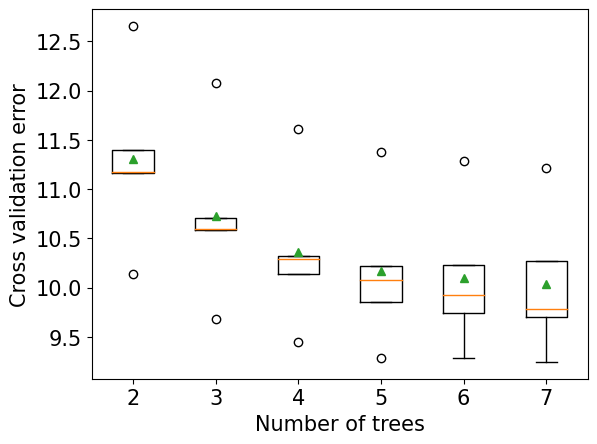

In [105]:
def get_models():
    models = dict()
    for n in range(2, 8):
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 9.881 (1.215)
>2 9.709 (1.154)
>3 9.744 (1.066)
>4 9.963 (0.958)
>5 10.037 (1.071)
>6 10.021 (0.968)


Text(0.5, 0, 'Depth of each tree')

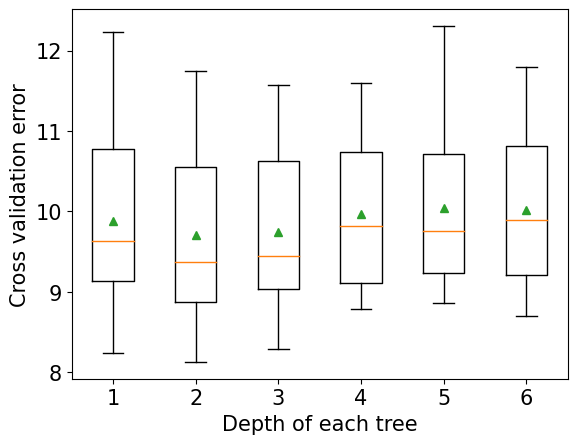

In [106]:
def get_models():
    models = dict()
    for i in range(1, 7):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0300 9.7 (1.2)
>0.0400 9.7 (1.1)
>0.0500 9.6 (1.1)
>0.0600 9.6 (1.1)


Text(0.5, 0, 'Learning rate')

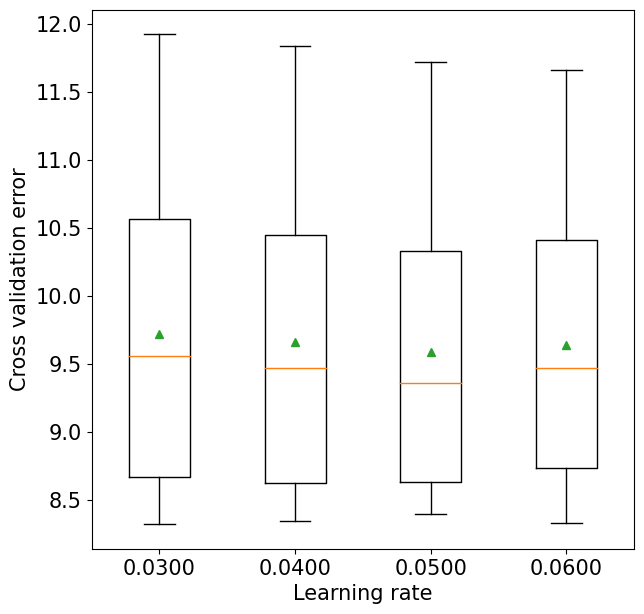

In [109]:
def get_models():
    models = dict()
    for i in [0.03, 0.04, 0.05, 0.06]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.2000 10.3 (1.1)
>0.2250 10.3 (1.1)
>0.2500 10.1 (1.1)
>0.2750 10.2 (1.0)


Text(0.5, 0, 'reg_lambda')

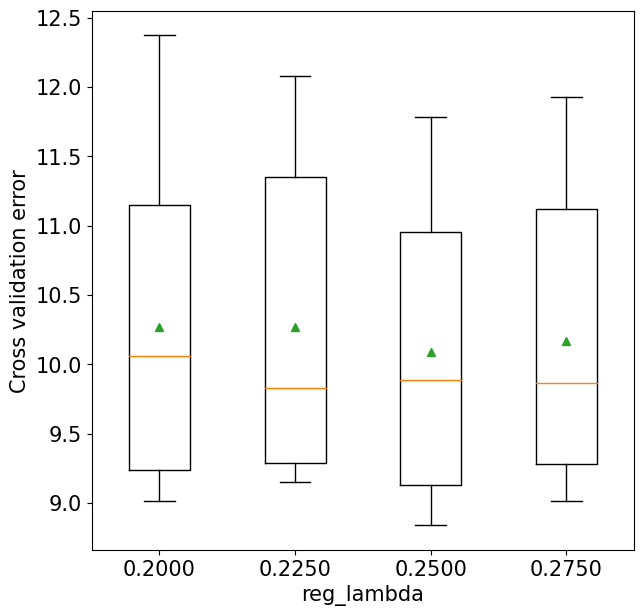

In [112]:
def get_models():
    models = dict()
    for i in [0.200, 0.225, 0.250, 0.275]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [114]:
param_grid = {'n_estimators':[3],
              'max_depth': [2, 3],
              'learning_rate': [0.050, 0.055],
              'reg_lambda':[0.230, 0.240, 0.250]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train3, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimal parameter values = {'learning_rate': 0.055, 'max_depth': 3, 'n_estimators': 3, 'reg_lambda': 0.23}
Optimal cross validation R-squared =  -0.2618014085546869


In [13]:
model_XG = xgb.XGBRegressor(n_estimators=3, max_depth=3, learning_rate = 0.055, reg_lambda=0.23, random_state=1,).fit(X_train3, y_train)

### AdaBoost

>3 11.040 (0.523)
>4 10.681 (0.521)
>5 11.013 (0.590)
>6 11.019 (0.610)
>7 11.174 (0.596)
>8 11.213 (0.489)
>9 11.263 (0.568)
>10 11.448 (0.492)
>11 11.629 (0.518)
>12 11.706 (0.527)
>13 11.887 (0.438)
>14 11.941 (0.472)


Text(0.5, 0, 'Number of trees')

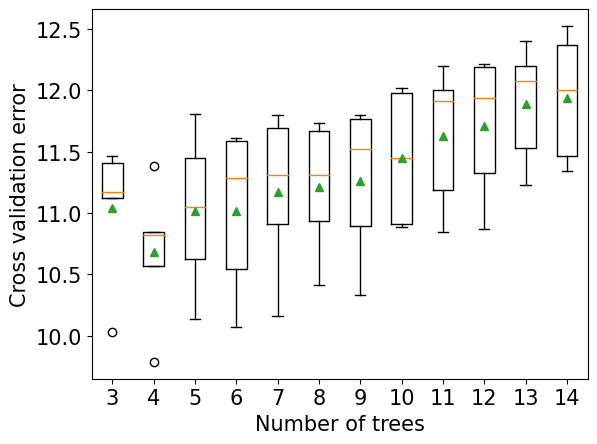

In [116]:
def get_models():
    models = dict()
    for n in range(3, 15):
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 12.522 (1.104)
>2 12.316 (0.886)
>3 13.719 (1.611)
>4 14.086 (0.346)
>5 12.150 (0.610)
>6 10.886 (0.854)
>7 10.239 (1.056)
>8 9.849 (1.195)
>9 9.838 (1.234)
>10 9.739 (1.213)


Text(0.5, 0, 'Depth of each tree')

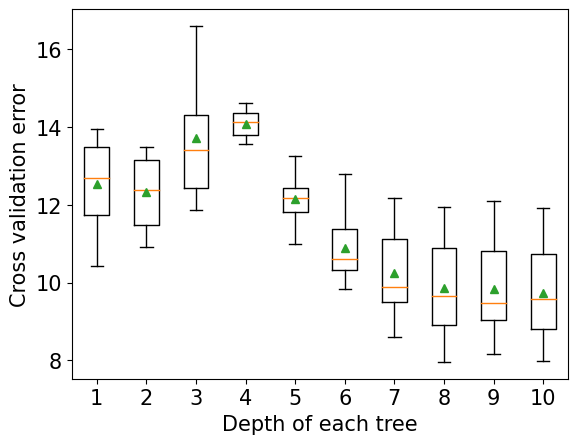

In [117]:
def get_models():
    models = dict()
    for i in range(1,11):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train3, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [118]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [4]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=6)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train3, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -112.357355 using {'base_estimator': DecisionTreeRegressor(max_depth=5), 'n_estimators': 4}


In [14]:
model_ADA = AdaBoostRegressor(n_estimators=4, base_estimator=DecisionTreeRegressor(max_depth=5), random_state=1).fit(X_train3, y_train)

c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### RF

In [120]:
warnings.filterwarnings("ignore")

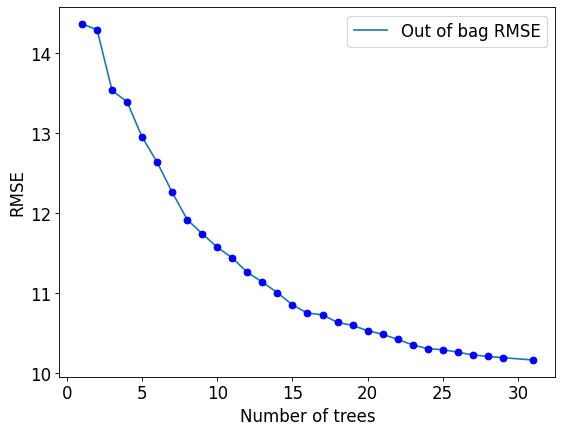

In [123]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in np.linspace(1, 31, 30, dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1, max_features="sqrt",
                                   n_jobs=-1, oob_score=True).fit(X_train3, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

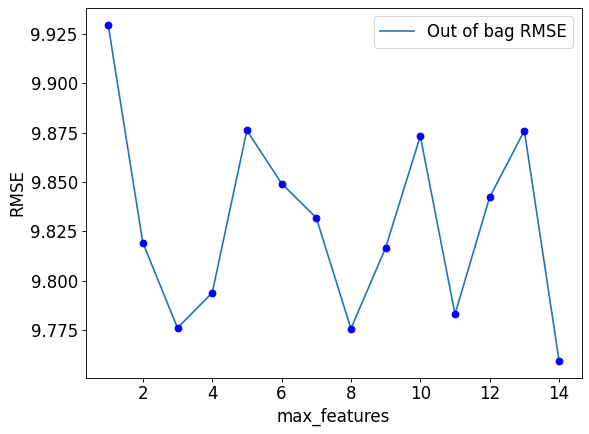

In [124]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in range(1, 15):
    model = RandomForestRegressor(n_estimators=100, random_state=1, max_features=i,
                                   n_jobs=-1, oob_score=True).fit(X_train3, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.legend()

In [125]:
params = {'n_estimators': [10, 12, 14, 16],
          'max_features': [2, 3]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train3, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (16, 3)
Best score (R-squared) =  0.23000914607020784


In [15]:
model_RF = RandomForestRegressor(n_estimators=16, max_features=3, random_state=1, n_jobs=-1).fit(X_train3, y_train)

### SVM

In [21]:
SVM = SVR()

param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 
              'C': (0.01, 0.1, 1, 10), 
              'degree': (2, 3, 4),
              'gamma': (0.001, 0.01, 0.1, 1)}

grid_search = RandomizedSearchCV(SVM, param_grid, scoring = 'accuracy', random_state=1, verbose = 2, n_iter=5, n_jobs = -1)
grid_search.fit(X_train3, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
optimal_kernel = grid_search.best_estimator_.kernel
optimal_C = grid_search.best_estimator_.C
optimal_degree = grid_search.best_estimator_.degree
optimal_gamma = grid_search.best_estimator_.gamma

model_SVM = SVR(kernel=optimal_kernel, C=optimal_C, degree=optimal_degree, gamma=optimal_gamma).fit(X_train3, y_train)

### ElasticNet

In [16]:
model_ENET = ElasticNetCV(l1_ratio=0.5, alphas=[0.1, 0.5, 1.0])
model_ENET.fit(X_train3, y_train)

ElasticNetCV(alphas=[0.1, 0.5, 1.0])

### Ensemble

In [17]:
model_ensemble= StackingRegressor(estimators = [('XG', model_XG),
                                                ('ADA', model_ADA),
                                                ('RF', model_RF),
                                                ('ENET', model_ENET)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train3, y_train)

c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: Futu

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('XG',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_ty...
                                            n_estimators=3, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...)),
                              ('ADA',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                                                 n_estimators=4,
                                                 random_state=1)),
                              ('RF',
                               RandomForestRegressor(max_features=3,
                                                     n_estimators=16, n_jobs=-1,
                                                     random_state=1)),
                              ('ENET', ElasticNetCV(alphas=[0.1, 0.5, 1.0]))],
                  final_estimator=LassoCV())

In [18]:
model_ensemble.final_estimator_.coef_

array([1.39050776, 0.16359235, 0.34690299, 0.47519311])

## Prediction

In [24]:
pred = model_ensemble.predict(X_test3)

pred_v22 = pd.DataFrame(index=range(X_test3.shape[0]), columns=range(2))
pred_v22.columns = ['id', 'y']
pred_v22['id'] = col_id
pred_v22['y'] = pred
pred_v22

,id,y
0,5380,5.913162
1,5381,9.011139
2,5382,3.179092
3,5383,5.692480
4,5384,12.634426
...,...,...
4398,9778,2.829357
4399,9779,8.869255
4400,9780,11.418395
4401,9781,13.245206


In [25]:
pred_v22.to_csv('pred_v22.csv', index=True)